In [81]:
from jax.config import config
config.update("jax_enable_x64", True)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import pickle
import scipy.optimize
from hyperion.utils import cherenkov_ang_dist, ANG_DIST_INT
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

import sys
sys.path.append("../gnn_testbed")
from gnn_testbed.event_generation import (
    Detector,
    make_line,
)
from gnn_testbed.event_generation.photon_propagation import make_generate_photons_nn, source_to_model_input, PhotonSource
from gnn_testbed.event_generation import generate_cascade
from hyperion.models.photon_arrival_time.net import PhotonArivalTimePars
from hyperion.models.photon_arrival_time.pdf import make_exp_exp_exp, sample_exp_exp_exp

%matplotlib inline


from jax import numpy as jnp
from jax import value_and_grad, jit
import pandas as pd
from glob import glob

import awkward as ak
from torch.autograd.functional import hessian, jacobian

In [2]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50
dark_noise_rate = 16 * 1E-6 # 1/ns

modules = make_line(0, 0, oms_per_line, dist_z, rng, dark_noise_rate, 0, efficiency=0.3)
modules += make_line(0, 50, oms_per_line, dist_z, rng, dark_noise_rate, 0, efficiency=0.3)
det = Detector(modules)


lc_links = {}
for i in range(60):
  
    links = list(range(max(i-1, (i//20)*20), min(i+2, (i//20+1)*20)))
    links.remove(i)
    lc_links[i] = links

height = 1500
radius = 200


In [59]:
def sph_to_cart(theta, phi=0):
    """Transform spherical to cartesian coordinates."""
    x = torch.sin(theta) * torch.cos(phi)
    y = torch.sin(theta) * torch.sin(phi)
    z = torch.cos(theta)
    
    out = torch.empty(3, device=device, dtype=torch.float)
    out[0] = x
    out[1] = y
    out[2] = z
    
    return out

def sph_to_cart_np(theta, phi=0, r=1):
    """Transform spherical to cartesian coordinates."""
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    return np.asarray([x, y, z])


In [71]:
def source_to_model_input_torch(module_coords, source_pos, source_dir):
    """Convert photon sources an module coordinates into neural net input."""

    source_targ_vec = module_coords - source_pos
    dist = torch.linalg.norm(source_targ_vec, dim=-1)
    angles = torch.arccos(torch.einsum("ak, k -> a", source_targ_vec, source_dir) / dist)

    inp_pars = torch.stack([angles, torch.log10(dist)], axis=1)
    return inp_pars


def expon_pdf(x, a):
    """Exponential PDF."""
    return 1 / a * torch.exp(-x[:, np.newaxis] / a)

def triple_exp(xs, parameters):
    
    scales = parameters[:, 0:3] * 100
    scales, indices = torch.sort(scales, dim=1)

    w1 = parameters[:, 3]
    w2 = parameters[:, 4]
    weights = torch.empty((parameters.shape[0], 3), device=device)
    weights[:, 0] = torch.sin(w1) * torch.cos(w2)
    weights[:, 1] = torch.sin(w1) * torch.sin(w2)
    weights[:, 2] = torch.cos(w1)
    weights = weights**2

    res = torch.log(
        weights[:, 0] * expon_pdf(xs, scales[:, 0])
        + weights[:, 1] * expon_pdf(xs, scales[:, 1])
        + weights[:, 2] * expon_pdf(xs, scales[:, 2])
    )

    return res


def uniform_triple_exp(xs, parameters):
    log_usf = parameters[:, -2]
    usf = 1 - 10 ** (-log_usf)
    out = torch.empty((xs.shape[0], parameters.shape[0]), device=device)
    out[xs < 2] = torch.log(usf * 1/2)
    out[xs >=2] = torch.log(1-usf) +triple_exp(xs[xs >=2]+2, parameters[:, :-2])
    return out

def poisson_utr_exp(times, amp_meas, amp_exp, parameters):
    log_nph = parameters[:, -1]
    surv_ratio = 10 ** log_nph / 300e7 
    n_ph_exp = amp_exp * surv_ratio   
    log_poisson_factor = amp_meas * torch.log(n_ph_exp) - n_ph_exp
    
    return log_poisson_factor, uniform_triple_exp(times, parameters)


module_positions = torch.tensor(det.module_coords, dtype=torch.float, device=device)
net = torch.load("data/arival_time_pars_net.dat")
net.to("cuda")


def eval_dist(times, amp_meas, amp_exp, pos, theta, phi, module_ix):
    cdir = sph_to_cart(theta, phi)
    model_in = source_to_model_input_torch(module_positions, pos, cdir)
    pdf_params = net(model_in).reshape(module_positions.shape[0], 7)
    
    pdf_eval = poisson_utr_exp(times, amp_meas, amp_exp, pdf_params[module_ix][np.newaxis, :])
    return pdf_eval
    

def eval_likelihood(event, amp, pos, theta, phi):
   
    cdir = sph_to_cart(theta, phi)
    model_in = source_to_model_input_torch(module_positions, pos, cdir)
    pdf_params = net(model_in).reshape(module_positions.shape[0], 7)
    
    likelihood = 0
    for i, times in enumerate(event):
        times = torch.tensor(times, device=device, dtype=torch.float)
        
        poisson_f, shape_f = poisson_utr_exp(times, amp, pdf_params[i][np.newaxis, :])
        
        likelihood += poisson_f + shape_f.sum()
    
    return likelihood
    
    
    

In [115]:
theta = np.radians(5)
theta2 = np.radians(20)
phi = 0
cdir = sph_to_cart_np(theta, phi)
cdir2 = sph_to_cart_np(theta2, phi)
pos = np.asarray([30., 40, 0])

amp = 1E10

gen_ph = make_generate_photons_nn("../hyperion/data/arival_time_pars_net.dat")
phsrc = PhotonSource(pos, amp, 0, cdir)
samples = gen_ph(det.module_coords, det.module_efficiencies, [phsrc])[30]

theta_t = torch.tensor(theta, device=device, dtype=torch.float)
theta2_t = torch.tensor(theta, device=device, dtype=torch.float)
phi_t = torch.tensor(phi, device=device, dtype=torch.float)
pos_t = torch.tensor(pos, device=device, dtype=torch.float)

xs = np.linspace(0, 500, 500)

#event, record = generate_cascade(det, pos, 0., cdir, n_photons=1E8,  pprop_func=gen_ph)
#event2, record2 = generate_cascade(det, pos, 0., cdir2, n_photons=1E9,  pprop_func=gen_ph)

In [140]:
xs_t = torch.tensor(xs, device=device, dtype=torch.float)
poiss, shape = eval_dist(xs_t, amp, pos_t, theta_t, phi_t, 30)
pdf_val = poiss + shape
plt.plot(xs, pdf_val.detach().cpu())

poiss, shape = eval_dist(xs_t, amp, pos_t, theta2_t, phi_t, 30)
pdf_val = poiss + shape
plt.plot(xs, pdf_val.detach().cpu())




RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [128]:
def make_wrap(t, amp, pos_t, mod_index):
    def wrap(theta, phi):
        res = eval_dist(torch.tensor([t], device=device, dtype=torch.float), amp, pos_t, theta, phi, mod_index)
        return res[0] + res[1]
    return wrap

hess_m = 0
for t in samples[:100]:
    wrap = make_wrap(t, amp, pos_t, 30)
    hess = hessian(wrap, (theta_t, phi_t), strict=True)
    hess_m += np.asarray([[hess[0][0].detach().cpu().numpy(), hess[0][1].detach().cpu().numpy()],
                     [hess[1][0].detach().cpu().numpy(), hess[1][1].detach().cpu().numpy()]])
    
hess_m /= 100

In [125]:
wrap = make_wrap(samples[0], amp, pos_t, 30)
hess = hessian(wrap, (theta_t, phi_t), strict=True)

In [126]:
hess

((tensor(-900108.5625, device='cuda:0'), tensor(-28789.0723, device='cuda:0')),
 (tensor(-28789.0703, device='cuda:0'), tensor(-15670.5957, device='cuda:0')))

In [131]:
np.degrees(np.sqrt(np.linalg.inv(-hess_m)[0, 0]))

0.06224788

[]

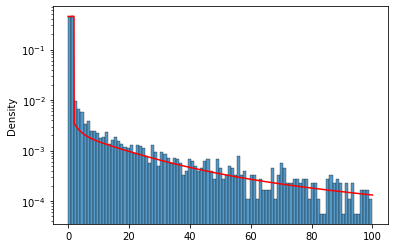

In [55]:

model_in = source_to_model_input(det.module_coords, [phsrc])

xs = np.linspace(0, 100, 1000)
xs_t = torch.tensor(xs, device=device, dtype=torch.float)

plt.plot(xs, torch.exp(uniform_triple_exp(xs_t, pdf_params)[:, 30]).detach().cpu(), color="r")

times = 
sns.histplot(times, bins = np.linspace(0, 100, 100), stat="density")
plt.semilogy()


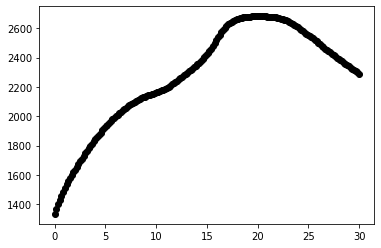

In [58]:
thetas = torch.linspace(np.radians(0), np.radians(30), 180)
for theta in thetas:
    plt.plot(np.degrees(theta.cpu().detach()), eval_dist(event2, 0.3*1E9, pos, theta, phi).cpu().detach(), "ok")


In [32]:
def wrap(theta, phi):        
    return eval_dist(event, 1E6, pos, theta, phi)

theta = torch.tensor(20., device=device)#
phi = torch.tensor(0., device=device)
hess = hessian(wrap, (theta, phi), strict=True)

In [33]:
hess

((tensor(-3.4984, device='cuda:0'), tensor(1.6891, device='cuda:0')),
 (tensor(1.6891, device='cuda:0'), tensor(2.5304, device='cuda:0')))

In [24]:

hessian(lambda theta, phi: net(source_to_model_input(module_positions, pos, sph_to_cart(theta, phi))).reshape(module_positions.shape[0], 7).sum(), (theta, phi))

((tensor(0., device='cuda:0'), tensor(0., device='cuda:0')),
 (tensor(0., device='cuda:0'), tensor(0., device='cuda:0')))

In [228]:
xs = torch.linspace(0, 200, 1000, device=device)
plt.plot(xs.detach().cpu(), uniform_triple_exp(xs, pdf_params[10, :-1]).detach().cpu())
plt.plot(xs.detach().cpu(), uniform_triple_exp(xs, pdf_params2[10, :-1]).detach().cpu())
#plt.semilogy()

IndexError: too many indices for tensor of dimension 1

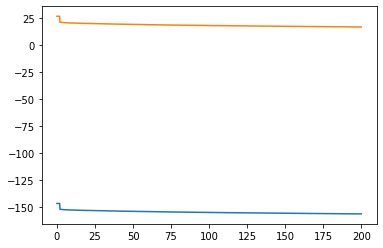

In [200]:
xs = torch.linspace(0, 200, 1000, device=device)
plt.plot(xs.detach().cpu(), poisson_utr_exp(1E5, xs, *pdf_params[10, ]).detach().cpu())
plt.plot(xs.detach().cpu(), poisson_utr_exp(1E5, xs, *pdf_params2[10, ]).detach().cpu())
#plt.semilogy()

In [139]:
torch.autograd.functional.hessian

tensor(0.0153, device='cuda:0', grad_fn=<RsubBackward1>)

In [126]:
pdf_params2[0]

tensor([ 0.1407,  0.4384,  0.7594,  0.7884,  0.6862,  0.0066, -6.5473],
       device='cuda:0', grad_fn=<SelectBackward>)

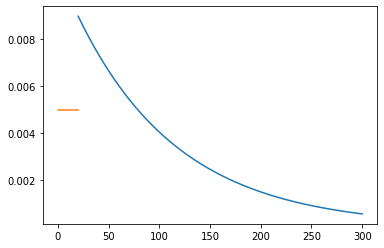

In [179]:
xs = np.linspace(0, 300, 1000)
plt.plot(xs[xs > 20], 0.9 * 1/100 * np.exp((-(xs[xs > 20]-20) / 100)))
plt.plot(xs[xs < 20], 0.1 * 1/20*np.ones((xs < 20).sum()))

In [180]:
def func(xs):
    xs = np.atleast_1d(xs)
    out = np.empty_like(xs)
    out[xs > 20] = 0.9 * 1/100 * np.exp((-(xs[xs > 20]-20)) / 100)
    out[xs <= 20] = 0.1 * 1/20*np.ones((xs <= 20).sum())
    return out

In [181]:
from scipy.integrate import quad

In [183]:
quad(func, 0, 1000)

(0.9999500936055827, 1.4619977228846892e-08)

In [178]:
quad(lambda xs: 0.9 * 1/100 * np.exp((-xs / 100)), 10, 1000)

(0.8143128162955776, 1.7995457225188243e-14)